<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Vector Space Model

Many methods, algorithms, and models in Natural Language Processing (NLP) and Text Mining require or at least benefit from inputs that are of both numerical and of a fixed length/size. However, text data (e.g., sentences) can be of arbitrary length with words being categorical data. As such, most methods and algorithms do not accept plain text as an input. The Vector Space Model (VSM) is a fundamental concept in NLP and text mining to handle and analyze textual data. At its core, VSM transforms words, sentences, and documents into numerical representations called vectors. This simple yet powerful idea allows computers to process and understand human language in a mathematical framework, enabling tasks like search engines, recommendation systems, and document classification to function effectively.

One of the key motivations behind the Vector Space Model is the need to manage large volumes of unstructured text data. Traditional methods struggle with the complexity and ambiguity of natural language, but VSM offers a structured way to measure the similarity between pieces of text. By representing documents as vectors in a multi-dimensional space, we can use mathematical techniques to compare them based on their content. This capability is crucial for applications such as information retrieval, where finding the most relevant documents quickly and accurately is essential.

Moreover, the importance of VSM extends beyond its simplicity. It lays the groundwork for more advanced NLP models, including word embeddings like Word2Vec and sophisticated deep learning architectures like transformers. These modern techniques build on the idea of representing language as vectors, but with added complexity to capture deeper semantic relationships. Understanding VSM provides a solid foundation for exploring these cutting-edge technologies, making it an essential concept for anyone interested in the field of data science, machine learning, or artificial intelligence.

In an era where data-driven decision-making is critical, the ability to analyze and extract meaningful insights from text data is invaluable. The Vector Space Model remains a versatile and effective tool, whether you're developing a basic search algorithm or working on advanced natural language applications. Its role in bridging the gap between human language and computational analysis highlights why it continues to be a cornerstone in the study and application of NLP.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.vsm import *
from src.utils.plotting.vsm import *

---

## Motivating Example

Let's assume we are given the following training dataset to build a binary classifier to predict the category of a news article (e.g., politics, business, entertainment, sports, lifestyle, etc. To keep it very simple for a better understanding, we consider consider only single sentences as our input documents and only two class labels (*politics* and *sports*). In more detail, the table below shows our initial example dataset, but now including the documents $d_1$, $d_2$, ..., $d_7$ after case-folding to lowercase, lemmatization, stopword removal, and punctuation mark removal.

|   	| Sentence                                            	| Sentences (processed)    	| Class   	|
|-------|---------------------------------------------------------|------------------------------|-------------|
| $d_1$ | *The mayor was elected for this term and next term.*	| *mayor elect term term*  	| *politics*  |
| $d_2$ | *A mayor's goal for the next term is to win.*       	| *mayor goal term win*    	| *politics*  |
| $d_3$ | *The goal for this term was to win the vote.*       	| *goal term win vote*     	| *politics*  |
| $d_4$ | *This term's goals are next term's goals.*          	| *term goal term goal*    	| *politics*  |
| $d_5$ | *The goal of any team player is the win.*           	| *goal team player win*   	| *sports*	|
| $d_6$ | *A win for the team is a win for each player.*      	| *win team win player*    	| *sports*	|
| $d_7$ | *Players vote other players for another term.*      	| *player vote player term*	| *sports*	|

Now let's assume you want to train different models to see which one performs best. Some classification algorithms such as the Multinomial Naive Bayes algorithm can directly work on the words as inputs &mdash; however, available implementations such as the `MultinomialNB` class of the scikit-learn library do require the representation of the input documents as vectors. Other applicable classification algorithms include the K-Nearest Neighbor (KNN) algorithms as long as a meaningful pairwise similarity metric between two documents has been defined (e.g., the [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index)). But even a KNN classifier typically benefits from a vector representation as the use of vector-based similarity metrics (e.g., the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)) yield better results; as we will discuss in this notebook later.

Most importantly, however, classification algorithms such as Logistic Regression and Neural Networks require a fixed-sized numerical representation of each input. We therefore need to convert all sentences in such a representation we call vectors. One basic approach to create such vectors is by the extraction of hand-crafted features. For example, we could define the following (naive) list of features:

* **#chars**: number of characters
* **#tokens**: number of tokens (words, punctuation marks)
* **#nouns**: number of nouns
* **#entities**: number of named entities
* **#apostrophes**: number of apostrophes

Extracting these four features for all seven original sentences in our example corpus would give us the following document vectors:

|   	| #chars | #words | #nouns | #entities | #apostrophes |
|-------|:------:|:------:|:------:|:---------:|:------------:|
| $d_1$ | 50 	| 11 	| 3  	| 0     	| 0        	|
| $d_2$ | 43 	| 11 	| 3  	| 0     	| 1        	|
| $d_3$ | 43 	| 11 	| 3  	| 0     	| 0        	|
| $d_4$ | 40 	| 8  	| 4  	| 0     	| 2        	|
| $d_5$ | 39 	| 10 	| 4  	| 0     	| 0        	|
| $d_6$ | 44 	| 12 	| 4  	| 0     	| 0        	|
| $d_7$ | 44 	| 8  	| 3  	| 0     	| 0        	|

The problem with this approach is that finding good features that are (ideally) also easy to extract can be very tricky in practice. Given our example, it is not intuitive why the number of words or the number of nouns might be a good indicator whether a document should be labeled *politics* or *sports* &mdash; and the resulting feature vectors above do now show any obvious patterns. After all, the arguably most important features are the words themselves. For example, the word *"mayor"* is more likely to be associated with an article of class *politics* than of class *sports*. The Vector Space Model introduces a systematic way to encode the presence and importance of words in a document as a numerical vector.

---

## Fundamental Idea: Term-Document Matrix

The fundamental idea of the Vector Space model is to represent each document as a vector based on the vocabulary $V$ &dmash; the set of unique terms in a text corpus, where *term* can refer to unigrams (i.e., words), bigrams, trigrams, etc. As such, each document vector is vector of length $|V|$ where the elements of the vector reflect "some" representation of the words contained in the document; we will later see how different VSM represent differ with respect to the exact vector values. Combining the vectors for all documents in a corpus $D$ gives as the **Term-Document Matrix** where the rows represent the terms and the columns represent the documents. Assuming a set of terms $t_1, t_2, \dots, t_{|V|} \in V$, and the set of documents $d_1, d_2, \dots, d_{|D|} \in D$, we can visualize the Term-Document Matrix as a table shown below.

<table border="1">
  <tr>
    <th></th>
    <th>$\large d_1$</th>
    <th>$\large d_2$</th>
    <th>$\large d_3$</th>
    <th>$\large d_4$</th>
    <th>$\large d_5$</th>
    <th>$\large d_6$</th>
    <th>$\large \cdots$</th>
    <th>$\large d_{|D|}$</th>
  </tr>
  <tr>
    <th>$\large t_1$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large t_2$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large t_3$</th><td></td><td></td><td></td><td>$w_{3,4}$</td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large t_4$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large t_5$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large \vdots$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>$\large t_{|V|}$</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
</table>

where $w_{t,d}$ &mdash; $w_{3,4}$ as an example in the table above &mdash; represent the weight of the term $t$ with respect to document $d$. For our example dataset containing $|D|=7$ documents and a vocabulary of size $|V|=8$, the Term-Document Matrix visualized as a table is:

<table border="1">
  <tr>
    <th></th>
    <th>$\large d_1$</th>
    <th>$\large d_2$</th>
    <th>$\large d_3$</th>
    <th>$\large d_4$</th>
    <th>$\large d_5$</th>
    <th>$\large d_6$</th>
    <th>$\large d_7$</th>
  </tr>
  <tr>
    <th>elect</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>goal</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>mayor</th><td></td><td></td><td></td><td>$w_{3,4}$</td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>player</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>team</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>term</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>vote</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <th>win</th><td></td><td></td><td></td><td></td><td></td><td></td><td></td>
  </tr>
</table>

Here, $w_{3,4}$ is now the weight for *"mayor"* with respect to document $d_4$ (*"term goal term goal"*)

In the next section, we will go through the basic approach for how to calculate all weights $W_{t,d}$ of the Term Document Matrix. To this end, let's define our example dataset and extract the vocabulary from it.

In [2]:
# Training data
D = np.asarray([
    "mayor elect term term",
    "mayor goal term win",
    "goal term win vote",
    "term goal term goal",
    "goal team player win",
    "win team win player",
    "player vote player term"
])

labels = np.asarray(["politics", "politics", "politics", "politics", "sports", "sports", "sports"])

# Extract vocabulary (lexicogrpahically sorted for consistency)
V = sorted(set([word for doc in D for word in doc.split()]))

With the dataset and the vocabulary, we can initialize the Term Document Matrix. For this, we first create a Numpy array of size $|V|\times |D|$, with all values being $0$. This can easily be done using the built-in method `zeros()` of the Numpy library; see the code cell below:

In [3]:
tdm = np.zeros((len(V), len(D)), dtype=int)

To better visualize our matrix, we can convert this Numpy array to a Pandas DataFrame so we can print the Term-Document Matrix in a user-friendly manner.

In [4]:
df_tdm = pd.DataFrame(tdm, columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm = df_tdm.set_index(pd.Index(V))
df_tdm

,d1,d2,d3,d4,d5,d6,d7
elect,0,0,0,0,0,0,0
goal,0,0,0,0,0,0,0
mayor,0,0,0,0,0,0,0
player,0,0,0,0,0,0,0
team,0,0,0,0,0,0,0
term,0,0,0,0,0,0,0
vote,0,0,0,0,0,0,0
win,0,0,0,0,0,0,0


Again, what's now left is to calculate the weights of this Term-Document Matrix to yield meaning document vectors.

---

## Common Term Weights

Different ways to calculate weights in a Term-Document Matrix (TDM) exist because they serve different purposes in text analysis and information retrieval. The simplest method is **binary weighting**, where a term is assigned a value of 1 if it appears in a document and 0 otherwise. This approach is easy to implement but does not account for term frequency or document importance. A more refined approach is **Term Frequency (TF) weighting**, which assigns higher values to terms that appear more frequently within a document. However, frequently occurring words (e.g., "the," "is") might dominate, even if they do not carry much meaning. To counter this, **TF-IDF (Term Frequency-Inverse Document Frequency)** is often used. It adjusts TF by down-weighting terms that appear in many documents, emphasizing words that are more unique to specific documents. Let's look at those three common strategies in more detail.

### Binary Weights

#### Definitions & Calculations

The most basic way to calculate the Term-Document Matrix is using binary weights where $w_{t,d} = 1$ indicates the document $d$ contains the term $t$, independent of how many times; $w_{t,d} = 0$ indicates that document $d$ does not contain term $t$. The code cell implements the Term-Document Matrix with binary weights for our example corpus. After initializing the matrix with all zeros, we go through each document in our corpus $D$ and each term in our vocabulary $V$ and check if the term is in the document. If so, we set the corresponding matrix entry to 1.

In [5]:
# Initialize Term-Document Matrix
tdm_binary = np.zeros((len(V), len(D)), dtype=int)

for i, doc in enumerate(D):
    for j, term in enumerate(V):
        tdm_binary[j,i] = int(term in doc.split())

Again, we can use a Pandas DataFrame to visualize the resulting Term-Document Matrix.

In [6]:
df_tdm_binary = pd.DataFrame(tdm_binary, columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm_binary = df_tdm_binary.set_index(pd.Index(V))
df_tdm_binary

,d1,d2,d3,d4,d5,d6,d7
elect,1,0,0,0,0,0,0
goal,0,1,1,1,1,0,0
mayor,1,1,0,0,0,0,0
player,0,0,0,0,1,1,1
team,0,0,0,0,1,1,0
term,1,1,1,1,0,0,1
vote,0,0,1,0,0,0,1
win,0,1,1,0,1,1,0


From the matrix we can see, for example, that the word *"goal"* appears in the four documents $d_2$-$d_5$ (2nd row) and that document $d_2$ contains four words *"goal"*, *"mayor"*, *"team"*, and *"win"* (2nd column).

#### Basic Uses Cases

Binary weights indicate only the presence or absence of words in documents, with no differentiation between words of a document (e.g., with respect to the number of occurrences). For more sophisticated downstream tasks using the Term-Document Matrix, this is typically too limiting as we arguably lose useful information by reducing the weights to only $0$ or $1$. However, there are meaningful use cases that utilize a Term-Document Matrix with binary weights to filter documents.

##### Document Filtering

Assume we want to quickly find all documents containing the term *"vote"*, we only need to look at the corresponding row to see for which document there is a $1$ in the row. For example, to find all documents that contain the term *"vote"*, we first need to find the corresponding row in our Term-Document Matrix. We can accomplish by getting the index/position of *"vote"* in our vocabulary $V$ since the matrix rows are sorted in line with the terms in the vocabulary. Once we have the row, we can find all column indices where the row contains a $1$ using the built-in `argwhere()` method of Numpy. This method returns the indices of elements in an array that satisfy a specified condition. This is particularly useful for locating the positions of non-zero or condition-satisfying elements in multidimensional arrays. Since `argwhere()` returns a 2D array, we also use the built-in method `flatten()` to convert it to a simple 1D array.

**Your turn:** In the code cell below, change the *"vote"* to any other term from the vocabulary to see if the returned documents are as expected.

In [7]:
row = tdm_binary[V.index("vote")]

for idx in np.argwhere(row > 0).flatten():
    print(D[idx])

goal term win vote
player vote player term


This means, we have just implemented a very simple document retrieval engine where we can find documents based on keywords. Of course, this approach is extremely limited as it only supports filtering documents by using only a single search term &mdash; which must match exactly! &mdash; and it does not come with a ranking of the results with respect to some relevance score. However, the purpose was merely to show some basic use case for a Term-Document Matrix with binary weights.

##### Jaccard Similarity

The Term-Document Matrix with binary weights represents the **Set-of-Words** representation of a text document, since each document is represented by the set of words contained on the document, i.e., without duplicates and without any consideration of the sequential nature of the original document. Considering text documents as sets allows the application of set-based similarity metrics, with the Jaccard Similarity a very popular metric. The Jaccard Similarity (also known as the Jaccard Index) is a statistical measure used to compare the similarity and diversity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets. This metric is commonly used in fields like data mining, natural language processing, and information retrieval to measure the similarity between datasets, documents, or binary vectors. The formula for the Jaccard Similarity is:

$$\large
sim_{jaccard}(A,B) = \frac{|A\cap B|}{|A\cup B|}
$$

where $A$ and $B$ are two sets, $|A\cap B|$ represents the number of elements common to both sets (the intersection), and $|A\cap B|$ represents the total number of unique elements across both sets (the union). The resulting value ranges from 0 to 1, where 0 indicates no similarity (completely disjoint sets) and 1 indicates identical sets. While we can directly work with sets of words (or generally: terms) to calculate the Jaccard Similarity between two documents, using the Term-Document Matrix with binary weights can make the involved calculation much simpler and more efficient to implement.

Consider the following document vectors for the two documents $d_2$ and $d_3$ from our given matrix (2nd and 3rd column)
* $d_1$: $[0, 1, 1, 0, 0, 1, 0, 1]$
* $d_2$: $[0, 1, 0, 0, 0, 1, 1, 1]$

To calculate the size of intersection, notice that we are looking for the number of entries that are $1$ at the same positions in both vectors. We can find those positions by the element-wise multiplication of both vectors. Only where both vectors have a $1$ at the same positions, the result will also be a $1$, and $0$ otherwise. We then can simply add all elements (i.e., all $1$s) in the resulting vector to get the size of the intersection. Similarly, the union of both vectors is represented by the positions where $d_1$, $d_2$, or both have a $1$. We can find those positions by the element-wise addition of both vectors. Of course, for positions where both vectors have a $1$ the result will be $2$. To avoid double counting the elements, we can simply use the sign function. The method `jaccard_similarity()` in the code cell below implements this vector-based calculation of the Jaccard Similarity:

In [8]:
def jaccard_similarity(u, v):
    return np.sum(u*v) / np.sum(np.sign(u+v))

where $u$ and $v$ are some vectors containing only $0$s and $1$s, and both vectors must have the same size. We can now pick any document identified by its ID to calculate their Jaccard Similarity. For example, the code cell below performs this calculation for the documents $d_2$ and $d_3$. Just notice that we need to subtract $-1$ from the ID to get the correct column index since the columns are indexed from $0, 1, 2, \dots, |D|-1$.

In [9]:
doc_id1, doc_id2 = 2, 3

u, v = tdm_binary[:,doc_id1-1], tdm_binary[:,doc_id2-1]

print(f"The Jaccard Similarity between documents d{doc_id1} and d{doc_id2} is: {jaccard_similarity(u, v)}")

The Jaccard Similarity between documents d2 and d3 is: 0.6


Once we have some measure for the similarity between two text documents, we can apply any machine learning method that relies on the pairwise similarity of data samples. Common examples for such methods are clustering as well as K-Nearest Neighbor (KNN) algorithms for classification and regression. Of course, the Jaccard Similarity assumes the Set-of-Words representation of documents &mdash; that is, a Term-Document Matrix with binary weights &mdash; which ignores the frequency to words or any other way to capture the importance of terms.

### Term Frequency Weights

#### Definitions & Calculations

The most straightforward extension that goes beyond simply indicating the presence or absence of terms in a document is to also represent the term frequencies, that is, now $w_{t,d}$ reflects the number of times term $t$ appears in document $d$. The intuition is that terms that occur more often are more important. Notice that this assumption strongly suggests the removal of stopwords &mdash; at least when assuming terms to be only unigrams (i.e., individual words) &mdash; because those are very common and typically do not carry much information. Implementing the calculation of the Term-Document Matrix with term frequencies is again very simple in Python. The `count()` method in Python is used to return the number of occurrences of a specified element within a list (or other iterable types like tuples). It scans through the list and counts how many times the given value appears. The code cell below uses this method to calculate all weights $w_{t,d}$ for the Term-Document Matrix:

In [10]:
# Initialize Term-Document Matrix
tdm_tf = np.zeros((len(V), len(D)), dtype=int)

for i, doc in enumerate(D):
    for j, term in enumerate(V):
        tdm_tf[j,i] = doc.split().count(term)

As usual, let's visualize the matrix by means of a Pandas DataFrame.

In [11]:
df_tdm_tf = pd.DataFrame(tdm_tf, columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm_tf = df_tdm_tf.set_index(pd.Index(V))
df_tdm_tf

,d1,d2,d3,d4,d5,d6,d7
elect,1,0,0,0,0,0,0
goal,0,1,1,2,1,0,0
mayor,1,1,0,0,0,0,0
player,0,0,0,0,1,1,2
team,0,0,0,0,1,1,0
term,2,1,1,2,0,0,1
vote,0,0,1,0,0,0,1
win,0,1,1,0,1,2,0


From looking at that matrix, we can now tell that, for example, document $d_4$ contains the term *"goal"* twice. Since the Term-Document Matrix now reflects the number of occurrences of terms in documents, it reflects a **Bag-of-Words** representation of document. Compared to a set, a bag (or multiset) considers duplicates. This allows us to capture more information in document vectors compared to used binary weights, i.e., a Set-of-Words representation. The common assumption for many downstream tasks is that &mdash; ignoring stopwords for the here &mdash; more frequent terms are considered more important.

#### Basic Use Case

The Bag-of-Word representation is the expected input for training a Multinomial Naive Bayes (MNB) classifier. In fact the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) class of the scikit-learn package expects the Term-Document Matrix as the input. While the deeper explanation of the MNB classification algorithm is beyond this scope here, the code cell below shows a simple example of how to use the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) class to train an MNB classifier over our example dataset. Notice that we first have to transpose the Term-Document Matrix using `tdm_tf.T` since the `fit()` method assumes a Document-Term Matrix as input, where the rows reflect the documents and the columns the terms.

In [12]:
mnb_classifier = MultinomialNB().fit(tdm_tf.T, labels)

We can now use this train classifier to predict the class (*politics* or *sports*) for a new document. In the code cell below, we first define a test document. To keep it simple, we again already assume that the same preprocessing steps like for the training corpus &mdash; that is, case-folding, stop removal, punctuation mark removal, and lemmatization &mdash; has been performed. Of course, we also have to convert the document into its corresponding document vector with respect to vocabulary $V$. This vector we can then give to the `predict()` method of the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) class to get the predicted class.

**Your turn:** Try a different test document to see how it affects the prediction and if it matches your expectations.

In [13]:
doc_test = "mayor team term"
#doc_test = "player team term"
#doc_test = "team term elect"
#doc_test = "team vote victory"

# Create document vector (same steps as creating Term-Document Matrix)
doc_test_tf = np.zeros((len(V), 1), dtype=int)
for j, term in enumerate(V):
    doc_test_tf[j,0] = doc_test.split().count(term)

# Print the document vector
print(doc_test_tf.T[0])

# Predict class of test document
print(f"The predicted class for the sentence '{doc_test}' is: {mnb_classifier.predict(doc_test_tf.T)[0]}")

[0 0 1 0 1 1 0 0]
The predicted class for the sentence 'mayor team term' is: politics


Have another look at the previous code. Appreciate that any word that might appear in the test document that is not in vocabulary $V$ will be ignored. For example, for the vector for the test document *"team term victory"* will contain only two $1$s, one for *"team"* and one for *"vote"*. The term *"victory"* will not be represented in the document vector. This is because each position/element in a document vector reflects a specific (and existing) term in the vocabulary. In other words, we ignore all terms that do not appear in our Term-Document Matrix.

### TF-IDF (Term Frequency &mdash; Inverse Document Frequency)

#### Definitions & Calculations

As the name suggests, TF-IDF (Term Frequency &mdash; Inverse Document Frequency) weights also consider the number of occurrences of term in a document as part of calculation of the weight values. However, TF-IDF extends this idea of using the raw term counts based on two observations to yield more meaningful weights the empirically often work better in practice.

**(1) Sublinear Term Frequencies.** The first observations that the raw term counts (i.e., the term frequencies) assume that the importance of a term in a document depends linearly on the number of occurrences of that term in that document. For example, consider two documents $d_A$ and $d_B$ that are of similar length that both contain the term *"mayor"*, and let's assume that *"mayor"* appears 10 times in $d_A$ and 100 times in $d_B$. While it is fair to say the term *"mayor"* is more indicative, informative, important to describe $d_B$ than $d_A$, saying that it is 10 times more important might be a very strong assumption. Therefore, to dampen the effect of the raw counts, the TF-IDF uses a sublinear function to calculate the term frequency weights. The most common choice if of a sublinear function is the logarithm, resulting in the following formula to calculate the term frequency weights $w_{t,d}$ of a term $t$ in a document $d$:

$$\large
w_{t,d} =
\begin{cases}
1 + \log{tf_{t,d}}, & tf_{t,d} > 0\\[0.5em]
0, &  \text{otherwise}
\end{cases}
$$

Note that the application of a sublinear function is optional and not fundamentally required. Whether you choose to apply a sublinear function or note depends on your assumption of the importance of whether a term should linearly scale with its frequency in the document or not. For example, the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class of the scikit-learn library does not apply a sublinear function by default.

**(2) Inverse Document Frequency.** Using simple term frequencies assumes that a term in a document is more important or informative for this document the more frequently it appears in the document. Let's assume that a corpus $D$ containing 1,000 documents (i.e.,, $|D| = 1000$). Let's assume that $D$ contains a document $d_i$ that contains the term *"mayor"* many times. Given its hight term frequency, we would say that *"mayor"* is an important term to describe the document $d_i$. However, now let's also assume that the term *"mayor"* also appears in many other documents of our corpus $D$ and not just in document $d_i$. Based on this observation we can make the argument that *"mayor"* is actually not really that useful to describe $d_i$. In other words, terms that are (very) common across most (or maybe even all) documents in a corpus are arguably not that important after all, even if they appear frequently in individual documents.

Let's look at a concrete example from our example corpus. In document $d_1 = $ *"mayor elect term term"*, the word *"term"* appears twice and the word *"elect"* only once. Based on the term frequencies alone, *"term"* would be considered more important than *"elect"* in $d_1$. However, *"term"* appears in 5 of the 7 documents in our example corpus. In contrast, *"elect"* only appears in $d_1$ and in no other document of the corpus. This idea of measuring how common a term $t$ is among all documents in a corpus $D$ is expressed using the inverse document frequency $idf_{t}$, and is (typically) calculated as follows:

$$\large
idf_{t} = \log{\frac{|D|}{df_t}}
$$

where $df_t$ is the number of documents in $D$ that contain the term $t$. Again, the logarithm is used to dampen the effect. In short, $idf_{t}$ is an inverse measure of a term's importance, relevance, informativeness, etc. We now have both components to calculate the TF-IDF weights for the Term-Document Matrix. Putting both equations together gives us:

$$\large
w_{t,d} = (1 + \log{tf_{t,d}}) \cdot \log{\frac{|D|}{df_t}}
$$

if $tf_{t,d} > 0$; otherwise $w_{t,d} = 0$. To see its effect, we can calculate the weights $w_{\text{"}term\text{"},d_1}$ and $w_{\text{"}elect\text{"},d_1}$ to see if it matches our intuition from above. First, for word *"term"* in document $d_1$ we get:

$$
\begin{align}
\large w_{\text{"}term\text{"},d_1} &= \large (1 + \log{tf_{\text{"}term\text{"},d_1}}) \cdot \log{\frac{|D|}{df_{\text{"}term\text{"}}}}\\[0.5em]
&= \large (1 + \log{2}) \cdot \log{\frac{7}{5}} = 0.190
\end{align}
$$

Note that we use the logarithm base 10 for this calculation; in practice, the choice of the base hardly matters. Now we can do the same calculation for word *"elect"* in document $d_1$:

$$
\begin{align}
\large w_{\text{"}elect\text{"},d_1} &= \large (1 + \log{tf_{\text{"}elect\text{"},d_1}}) \cdot \log{\frac{|D|}{df_{\text{"}elect\text{"}}}}\\[0.5em]
&= \large (1 + \log{1}) \cdot \log{\frac{7}{1}} = 0.845
\end{align}
$$

Despite appearing only once in document $d_1$, the word *"elect"* has a higher TF-IDF weight compared to word *"term"* since *"elect"* only appears in $d_1$ (while *"term"* appears in 5 documents in total). Thus, the inverse document frequency of *"elect"* is much higher than the one of *"term"*, yielding respective TF-IDF weight calculated above, matching our initial intuition about the importance of both terms for document $d_1$.

Lastly, let's calculate all the TF-IDF weights for our Term-Document Matrix for our example corpus. Of course, we need to know how many documents each term of our vocabulary appears. In other words, we need to calculate the document frequencies $df_t$ for each term. The code cell accomplishes this by iterating over each document in the corpus and each word in the document. To avoid any double counts, we convert each document from a bag (i.e., multiset of words) to a proper set of words.

In [14]:
# Initialize dictionary to store the document frequency for each term
df_values = defaultdict(int)

for doc in D:
    for term in set(doc.split()):
        df_values[term] = df_values[term] + 1

Before we continue, we should have a brief look at the document frequencies to check if they match our expectations.

In [15]:
print(df_values)

defaultdict(<class 'int'>, {'elect': 1, 'mayor': 2, 'term': 5, 'win': 4, 'goal': 4, 'vote': 2, 'team': 2, 'player': 3})


Indeed, we see that the word *"term"* appears in 5 documents and the word *"elect"* in only 1 document; as we have already identified above. To compute the final TF-IDF weights, we can repurpose the code for calculating the basic term frequency weights. After all, the TF-IDF weights still incorporate the term frequency values. The code cell below makes only two changes. Firstly, only calculate any TF-IDF weights of the term frequency that are larger than $0$. This is to avoid any errors since $\log{0}$ is undefined. And secondly, the code cell implements our formula of calculating the TF-IDF weights, and it naturally uses the document frequency value we have already calculated.

In [16]:
# Initialize Term-Document Matrix
tdm_tfidf = np.zeros((len(V), len(D)), dtype=float)

for i, doc in enumerate(D):
    for j, term in enumerate(V):
        tf = doc.split().count(term)
        if tf > 0:
            tdm_tfidf[j,i] = (1 + np.log10(tf)) * np.log10(len(D) / df_values[term])

Using a Pandas dataframe, we can again nicely visualize the final Term-Document Matrix with the TF-IDF weights.

In [17]:
df_tdm_tfidf = pd.DataFrame(tdm_tfidf, columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm_tfidf = df_tdm_tfidf.set_index(pd.Index(V))
df_tdm_tfidf

,d1,d2,d3,d4,d5,d6,d7
elect,0.845098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
goal,0.000000,0.243038,0.243038,0.316200,0.243038,0.000000,0.000000
mayor,0.544068,0.544068,0.000000,0.000000,0.000000,0.000000,0.000000
player,0.000000,0.000000,0.000000,0.000000,0.367977,0.367977,0.478749
team,0.000000,0.000000,0.000000,0.000000,0.544068,0.544068,0.000000
term,0.190117,0.146128,0.146128,0.190117,0.000000,0.000000,0.146128
vote,0.000000,0.000000,0.544068,0.000000,0.000000,0.000000,0.544068
win,0.000000,0.243038,0.243038,0.000000,0.243038,0.316200,0.000000


If you check the first column, i.e., the document vector for document $d_1$, you will find the two weights $w_{\text{"}term\text{"},d_1} = 0.190$ and $w_{\text{"}elect\text{"},d_1} = 0.845$ we have previously calculated "by hand".

#### Considerations

It is important to point out that the formula for calculating the TF-IDF weights as presented above is not the only way to do it. There are different formulas to calculate TF-IDF weights because various applications require different ways of emphasizing term importance while balancing the impact of common words. TF-IDF is designed to reflect how important a word is to a document in a collection, but depending on the dataset and use case, different formulations can provide better accuracy and relevance. Variations in TF-IDF arise mainly from differences in how term frequency (TF) and inverse document frequency (IDF) are computed.

For term frequency (TF), some formulas use a simple raw count $tf_{t,d}$ of term occurrences, while others apply logarithmic scaling (e.g., $\log(1 + tf_{t,d}))$ to reduce the influence of extremely frequent words. Logarithmic scaling helps normalize term importance, preventing terms that appear too often from dominating the results. For inverse document frequency $idf_t$ of a term $t$, the standard formula is $\log(|D| / df_t)$. However, variations exist to prevent extreme values when terms appear in nearly all documents. A common adjustment is

$$\large
idf_t = \log{\left(\frac{|D| + 1}{df_t + 1} + 1 \right)}
$$

which ensures that a term $t$ that appears in all documents does not result in $df_t = 0$. In fact, this is the formula for calculating the inverse document frequency that the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class of the scikit-learn library implements.

These variations in TF-IDF formulas allow flexibility for different natural language processing (NLP) tasks. Search engines might prefer one formulation to improve ranking relevance, while text classification or clustering algorithms may use another for better term discrimination. By selecting an appropriate TF-IDF weighting scheme, you can optimize performance based on the specific characteristics of their text dataset. In other words, there is no theoretical underpinning that defines the best way to calculate the TF-IDF weights, and finding the best approach often relies on trial and error. That being said, TF-IDF weights typically outperform binary and (raw) term frequency weights for most tasks.

#### Basic Use Case

TF-IDF weights are the most common choice text mining algorithms that rely on the pairwise similarity between documents such as document clustering. Since the Vector Space Model represents each document as a vector, calculating the similarity (or distance) can be "converted" to calculating the similarity between two vectors. While different metrics that calculate the similarity between two vectors exist (e.g., Euclidean distance, dot product), the most commonly used metric for text documents is the cosine similarity (or cosine distance). The cosine Similarity is generally preferred when calculating the similarity or distance between document vectors because it focuses on the direction of the vectors rather than their magnitude. In text analysis, document vectors (e.g., TF-IDF) are often high-dimensional and sparse, meaning that raw frequency counts can be misleading. Two documents with similar word distributions may still have different lengths, which can distort similarity measures based on Euclidean distance or the dot product. Cosine similarity overcomes this issue by normalizing the vectors, ensuring that similarity is determined by the overlap in word usage rather than document length.

The `cosine_similarity()` function in the scikit-learn library is used to compute the cosine similarity between two or more vectors. It measures the cosine of the angle between vectors in a high-dimensional space, providing a value between -1 and 1 (or 0 to 1 for non-negative values like TF-IDF representations). A similarity score close to 1 indicates highly similar vectors (documents), while a score close to 0 means little to no similarity. This function is particularly useful in text analysis, where document vectors (e.g., from TF-IDF) need to be compared. It is efficient and works well with sparse data, making it a preferred choice for document clustering, search engines, and recommendation systems. Let's apply it to our Term-Document Matrix with TF-IDF weights.

In [18]:
cosine_sims = cosine_similarity(tdm_tfidf.T)

# Convert to Pandas DataFrame for a nicer visualization
df_cosine_sims = pd.DataFrame(cosine_sims, columns=[ f"d{d+1}" for d in range(len(tdm_tfidf.T)) ])
df_cosine_sims = df_cosine_sims.set_index(pd.Series([ f"d{d+1}" for d in range(len(tdm_tfidf.T)) ]))
df_cosine_sims

,d1,d2,d3,d4,d5,d6,d7
d1,1.000000,0.479661,0.041155,0.095771,0.000000,0.000000,0.036736
d2,0.479661,1.000000,0.320296,0.429726,0.241480,0.159747,0.043768
d3,0.041155,0.320296,1.000000,0.429726,0.241480,0.159747,0.650494
d4,0.095771,0.429726,0.429726,1.000000,0.280970,0.000000,0.101850
d5,0.000000,0.241480,0.241480,0.280970,1.000000,0.940537,0.321443
d6,0.000000,0.159747,0.159747,0.000000,0.940537,1.000000,0.326887
d7,0.036736,0.043768,0.650494,0.101850,0.321443,0.326887,1.000000


Two basic observations: Firstly, the similarity matrix is symmetric since the cosine similarity is symmetric &mdash; that is, the cosine similarity between $d_i$ and $d_j$ is the same as between $d_j$ and $d_i$. And secondly, the main diagonal of the similarity matrix is all $1$s since the cosine similarity between a vector with itself is always $1$. When looking the the similarity values &mdash; ignoring the main diagonal &mdash; we can see that the documents $d_5$ (*"goal team player win"*) and $d_6$ (*"win team player win"*) have with $0.94$ the highest cosine similarity. This is not surprising as these two documents are indeed very similar.

Being able to meaningfully calculate the pairwise similarity (or distance) between document vectors, allows us to apply clustering algorithms to identify interesting substructures in our corpus. To give an example, let's consider Agglomerative Clustering for our example dataset. Agglomerative clustering is a type of [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) that builds a hierarchy of clusters in a bottom-up manner. It starts by treating each data point (or document) as an individual cluster and then iteratively merges the closest clusters based on a chosen similarity measure (e.g., cosine similarity or Euclidean distance). This merging continues until all points belong to a single cluster or until a predefined number of clusters is reached. The results are often visualized using a dendrogram, which shows how clusters are formed at different levels. Agglomerative clustering is popular for text document clustering because it does not require specifying the number of clusters in advance. This is especially useful when the natural number of topic-based clusters is unknown. Additionally, it can use cosine similarity as a distance metric, which is well-suited for sparse and high-dimensional document vectors (e.g., TF-IDF representations). Hierarchical clustering provides a nested clustering structure, making it useful for organizing documents into hierarchical topics or subtopics in search engines, topic modeling, and taxonomy generation.

The [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class in scikit-learn is used to perform hierarchical agglomerative clustering. This class is particularly useful for text clustering, as it supports distance metrics like cosine similarity, which is ideal for sparse document representations (e.g., TF-IDF). Let's use this class to cluster our example corpus (a detailed discussion about the different parameters is beyond the scope here):

In [19]:
clustering = AgglomerativeClustering(linkage="single", metric="cosine", compute_distances=True).fit(tdm_tfidf.T)

Hierarchical clusterings are commonly visualized using dendrograms. A dendrogram is a tree-like diagram that shows how individual data points or clusters are merged step by step, providing insight into the hierarchical structure of the data. Each branch represents a merge between clusters, and the height of the merge indicates the distance (or dissimilarity) between clusters. Cutting the dendrogram at different heights allows users to choose different numbers of clusters. In the context of text document clustering, a dendrogram is useful for exploring relationships between documents and identifying natural clusters without specifying the number of clusters in advance. It helps in topic discovery, taxonomy creation, and document classification by showing how similar documents are grouped together. In the code cell below, we provide and use the method `plot_dendrogram()` to show the result of clustering.

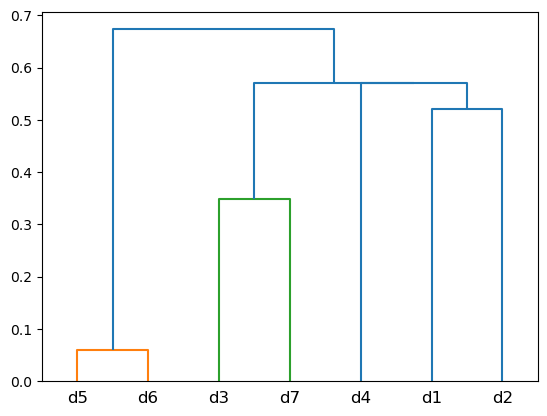

In [20]:
plt.figure()
plot_dendrogram(clustering)
plt.gca().set_xticklabels([ f"d{int(tick.get_text())+1}" for tick in plt.gca().get_xticklabels()])
plt.show()

Unsurprisingly, the dendrogram shows that documents $d_5$ and $d_6$ are the most similar documents and were therefore merged first into a new cluster. The next pair of documents (i.e., clusters containing only one document) that got merged are $d_3$ and $d_7$, and so on. The dendrogram also shows us that documents $d_5$ and $d_6$ are rather different compared to the rest of the documents in our example dataset, since they got merged last into the final single cluster.

---

## Practical Applications & Extensions

So far, we focused on a very small example corpus to clearly understand the ideas behind the Vector Space Model and the most common strategies to calculate the weights in Term-Document Matrix. When working with large, real-world text corpora, there are additional considerations and extensions to that basic idea of vectorizing of documents to ensure well-performing downstream task utilizing those document vectors.

### Calculating Term-Document Matrices with scikit-learn

#### Term Frequency Weights

The [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class in the scikit-learn library converts a corpus of text documents into a matrix of token/term/word counts, i.e., term frequencies. Each row in the resulting matrix represents a document, and each column represents a unique word from the corpus, with the values indicating the frequency of that word in the document. Notice that this is strictly speaking a Document-Term Matrix which is simply the transpose of a Term-Document Matrix. The [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) offers various preprocessing options, such as removing stop words, converting text to lowercase, setting n-gram ranges, and applying tokenization rules. It also allows control over vocabulary size by limiting the number of features to the most frequent words. In the code cell below, for our small example dataset that is already preprocessed, we simply use the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with its default values.

In [21]:
count_vectorizer = CountVectorizer()

The `fit_transform()` method of the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class in scikit-learn performs two main steps: fitting the model to the input text data by learning the vocabulary (i.e., unique words) and transforming the text into a matrix representation where each row corresponds to a document, and each column represents a word's frequency in that document. To extract the learned vocabulary, we can use the `get_feature_names_out()` method. Here, we need it only to visualize the Term-Document Matrix.

In [22]:
tdm_tf_sklearn = count_vectorizer.fit_transform(D)
vocab_sklearn = count_vectorizer.get_feature_names_out()

As before, we can create a Pandas DataFrame that takes the learned Term-Document Matrix and vocabulary as input to nicely plot the matrix. Notice that we transform the matrix since `fit_transform()` will return a Document-Term Matrix but we want to show the Term-Document Matrix for consistency.

In [23]:
df_tdm_tf_sklearn = pd.DataFrame(tdm_tf_sklearn.A.T, index=list(vocab_sklearn), columns=[f"d{c}" for c in range(1, len(D)+1)])
df_tdm_tf_sklearn

,d1,d2,d3,d4,d5,d6,d7
elect,1,0,0,0,0,0,0
goal,0,1,1,2,1,0,0
mayor,1,1,0,0,0,0,0
player,0,0,0,0,1,1,2
team,0,0,0,0,1,1,0
term,2,1,1,2,0,0,1
vote,0,0,1,0,0,0,1
win,0,1,1,0,1,2,0


Unsurprisingly, the learned Term-Document Matrix matches the result above where we calculated all term frequencies "by hand". Keep in mind that the order of rows (i.e., terms) and the order of columns (i.e., documents) may differ depending on their sorting. However, this does not change the overall result since each weights $w_{t,d}$ still match.

#### TF-IDF Weights

Analogous to the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for calculating the raw term frequencies, the scikit-learn library also provides a class to calculate the TF-IDF weights, called the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Again, this class offers a wide range of input parameters &mdash; again removing stop words, converting text to lowercase, setting n-gram ranges, and applying tokenization rules &mdash; incl. parameters that affect the formula for calculating the TF-IDF weights. In the code cell below, we define a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to best matches our TF-IDF weights formula introduced above by using the natural logarithm as a sublinear function applied to the term frequencies. We also set `norm=False` to avoid the values being normalized, which is done by default.

In [24]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, norm=None)

Like the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) also provides the two methods `fit_transform()` and `get_feature_names_out()` to learn the Term-Document Matrix &mdash; only now with TF-IDF weights &mdash; and the vocabulary.

In [25]:
tdm_tfidf_sklearn = tfidf_vectorizer.fit_transform(D)
vocab_sklearn = count_vectorizer.get_feature_names_out()

Let's once again create a Pandas DataFrame to plot the Term-Document Matrix.

In [26]:
df_tdm_tfidf_sklearn = pd.DataFrame(tdm_tfidf_sklearn.A.T, index=list(vocab_sklearn), columns=[f"d{c}" for c in range(1, len(D)+1)])
df_tdm_tfidf_sklearn

,d1,d2,d3,d4,d5,d6,d7
elect,2.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
goal,0.000000,1.470004,1.470004,2.488933,1.470004,0.000000,0.000000
mayor,1.980829,1.980829,0.000000,0.000000,0.000000,0.000000,0.000000
player,0.000000,0.000000,0.000000,0.000000,1.693147,1.693147,2.866747
team,0.000000,0.000000,0.000000,0.000000,1.980829,1.980829,0.000000
term,2.180235,1.287682,1.287682,2.180235,0.000000,0.000000,1.287682
vote,0.000000,0.000000,1.980829,0.000000,0.000000,0.000000,1.980829
win,0.000000,1.470004,1.470004,0.000000,1.470004,2.488933,0.000000


Notice that the weights in this matrix differ quite significantly compared to the TF-IDF weight we calculated manually. This is expected since the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) uses a different formula to calculate the TF-IDF weights. As mentioned before, this class uses the natural logarithm (instead of the logarithm of base 10) and add smoothing to calculation of the inverse document frequencies; more specifically:

$$\large
idf_t = \log{\left(\frac{|D| + 1}{df_t + 1} + 1 \right)}
$$

Particularly for small datasets such as our example dataset containing only 7 documents, this modification of the formula will return noticeable different results compared to our basic definition of the formula for calculating inverse document frequencies.

### Beyond Unigrams

So far we only considered individual words (i.e., unigrams) as terms for the Term-Document Matrix. However, the Vector Space Model can trivially be extended to bigrams, trigrams and so on. For example, all vectorizer classes in the scikit-learn library allow users to specify the size of considered n-grams as a range given a minimum and maximum n-gram size. For a quick example, let's generate the Term-Document Matrix with term frequency weights for our example corpus considering unigrams, bigrams, and trigrams. The steps are exactly the same as above; we only need to specify the considered ngrams by setting the `ngram_range` parameter value which specifies the lower and upper length for the n-grams to be considered.

In [27]:
count_vectorizer3 = CountVectorizer(ngram_range=(1,3)) # Default is ngram_range=(1,1)

tdm3_tf_sklearn = count_vectorizer3.fit_transform(D)
vocab_sklearn = count_vectorizer3.get_feature_names_out()

df_tdm3_tf_sklearn = pd.DataFrame(tdm3_tf_sklearn.A.T, index=list(vocab_sklearn), columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm3_tf_sklearn

,d1,d2,d3,d4,d5,d6,d7
elect,1,0,0,0,0,0,0
elect term,1,0,0,0,0,0,0
elect term term,1,0,0,0,0,0,0
goal,0,1,1,2,1,0,0
goal team,0,0,0,0,1,0,0
goal team player,0,0,0,0,1,0,0
goal term,0,1,1,1,0,0,0
goal term goal,0,0,0,1,0,0,0
goal term win,0,1,1,0,0,0,0
mayor,1,1,0,0,0,0,0


Considering n-grams of larger sizes when calculating a Term-Document Matrix can be useful because it captures more contextual information from the text. In a traditional Bag-of-Words (BoW) model, using only unigrams (single words) ignores word order and the relationships between words. However, using bigrams (two-word sequences) or trigrams (three-word sequences) helps preserve some of this context, improving the model’s ability to understand phrases and dependencies. For example, in sentiment analysis, the unigram *"not"* and *"good"* may appear separately, but the bigram *"not good"* conveys a completely different meaning than *"very good"*.

N-grams of larger sizes are especially beneficial in tasks like text classification, search engines, and machine translation, where distinguishing between similar words in different contexts is important. For instance, in information retrieval, *"machine learning"* as a bigram is more meaningful than the individual words *"machine"* and *"learning"* separately. However, increasing the n-gram size also expands the vocabulary significantly, leading to higher computational costs and potential sparsity in the Term-Document Matrix. To balance this, models often use a combination of unigrams and bigrams or apply frequency thresholds to filter out rare n-grams &mdash; as we will discuss in the next section.

### Reducing Dimensionality

We just saw how considering terms beyond unigram can quickly increase the number of unique terms and hence the size of the resulting document vectors in a Term Document Matrix, even for very small text corpora like our example dataset. In practice, particularly when working with (very) large corpora, reducing the number of terms in a Term-Document Matrix is crucial for improving efficiency and effectiveness in text analysis and machine learning. A raw Term-Document Matrix often has a high dimensionality, with thousands or even millions of unique terms. This can lead to increased computational costs, memory usage, and processing time, making it impractical for many applications. Moreover, a high-dimensional feature space can cause the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), where models become inefficient and prone to overfitting due to the sparsity of meaningful data.

By reducing the number of terms, we can improve the interpretability and generalization of machine learning models. Ultimately, a more compact representation of text allows for better insights, faster training times, and improved predictive accuracy in NLP applications. A straightforward way to reduce the number of terms is to perform suitable text preprocessing steps. Techniques like case-folding, stopword removal, and stemming/lemmatization are common ways to reduce the total number of unique terms. However, this assumes that these preprocessing steps are suitable to be applied for a given text corpus and a given task. For example, particularly when including bigrams, trigrams, etc. as terms, stopwords are often not removed the preserve the original structure of the n-grams. A common example use case is sentiment analysis where we typically want to keep stop words such as *"not"*, *"n't"*, *"no"*, *"never"*, and others to capture negation (e.g., *"not good"*).

Beyond suitable preprocessing steps, two common techniques to reduce the number of terms is through filtering out terms that are considered unimportant. Both techniques are directly supported by all vectorizer implementations of the scikit-learn library. Firstly, The `max_features` parameter in scikit-learn's vectorizers limits the number of unique terms included in the vocabulary. It allows you to keep only the top-N most frequent terms while discarding less common terms with a text corpus. By setting `max_features`, you can ensure that only the most informative words are retained, which can improve model performance by focusing on key patterns in the data. If not specified, the vectorizer includes all unique words found in the corpus, which might lead to increased memory usage and longer computation times, especially with large datasets. The code cell below calculates the Term-Document matrix for our small example dataset, but restricting the matrix to the 6 most common terms.

In [28]:
count_vectorizer_max6 = CountVectorizer(max_features=6) # Default is None (= all features)

tdm_max6_tf = count_vectorizer_max6.fit_transform(D)
vocab_max6 = count_vectorizer_max6.get_feature_names_out()

df_tdm_max6_tf = pd.DataFrame(tdm_max6_tf.A.T, index=list(vocab_max6), columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm_max6_tf

,d1,d2,d3,d4,d5,d6,d7
goal,0,1,1,2,1,0,0
mayor,1,1,0,0,0,0,0
player,0,0,0,0,1,1,2
team,0,0,0,0,1,1,0
term,2,1,1,2,0,0,1
win,0,1,1,0,1,2,0


Of course, in practice using real-world datasets, values for `max_features` may often range from $10\text{k}\dots 50\text{k}$.

A second common technique to discard potentially unimportant terms revisits the intuition behind the inverse document frequencies. Recall that we introduced the $idf_t$ scores to lower the importance of terms that appear in many documents across a corpus. While this consideration is arguably meaningful, it implicitly also implies that terms that only appear in very few documents (or maybe only in 1 or 2) must be important. This perspective is less obvious since simply a misspelled word in a document can suddenly be considered an important term. A common strategy is therefore to consider only terms that appear in at least a minimum number of documents in the corpus. The `min_df` (minimum document frequency) parameter in scikit-learn's vectorizers controls the minimum number of documents a term must appear in to be included in the vocabulary. It can be set as an integer, which specifies the exact number of documents a term must occur in, or as a float, which represents the minimum proportion of documents (relative to the total corpus) that a term must appear in. For example, in the code cell below, we want to consider only terms that appear in at least 2 documents in our example dataset by setting `min_df=5`.

In [29]:
count_vectorizer_min2 = CountVectorizer(max_features=5) # Default is None (= all features)

tdm_min2_tf = count_vectorizer_min2.fit_transform(D)
vocab_min2 = count_vectorizer_min2.get_feature_names_out()

df_tdm_min2_tf = pd.DataFrame(tdm_min2_tf.A.T, index=list(vocab_min2), columns=[ f"d{d+1}" for d in range(len(D)) ])
df_tdm_min2_tf

,d1,d2,d3,d4,d5,d6,d7
goal,0,1,1,2,1,0,0
mayor,1,1,0,0,0,0,0
player,0,0,0,0,1,1,2
term,2,1,1,2,0,0,1
win,0,1,1,0,1,2,0


Note how this Term-Document Matrix is missing *"elect"*, as it only appears in document $d_1$.

The effects of `max_features` and `min_df` are typically much more pronounced for real-world text corpora. The reason for this is that the  distribution of a vocabulary typically follows [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), which means that in a large collection of texts, the frequency of words is highly skewed: a small number of words appear very frequently, while the vast majority of words appear rarely. Specifically, Zipf's Law states that if you rank words by frequency, the frequency of a word is inversely proportional to its rank. In other words, the most common word appears about twice as often as the second most common word, three times as often as the third, and so on. This results in a long-tail distribution, where a few words dominate the corpus while many words occur infrequently. Particularly the long tail consists of rare words, which can introduce sparsity into models and may need to be handled carefully &mdash; for example, by filtering them out using techniques like `min_df` when vectorizing the documents.

---

## Discussion & Limitations

The Vector Space Model is arguably a straightforward and meaningful way to convert text document into document vectors &mdash; that is, into numerical and fixed-sizes representations required to serve as valid input for many data analysis and machine learning tasks. The document vectors are derived from the corpus vocabulary, where each element/position in a vector reflects a specific term from the vocabulary. The values in the vectors &mdash; the weights $w_{t,d}$ in the Term-Document Matrix &mdash; can be calculated in different ways to (better) reflect a term's importance within a document. However, partially due to its simplicity, the Vector Space Model also has some important limitations.

**(1) No consideration of word order.** Fundamentally, the Vector Space Model (VSM) does not consider the order of words in a text document because it represents text as a bag of words (BoW), where each document is transformed into a vector of term frequencies or weighted term scores (e.g., TF-IDF). In this approach, the document is treated as a collection of words, disregarding their sequential arrangement. The advantage of this method is its simplicity and efficiency in converting text into a numerical format that can be processed by machine learning algorithms. However, ignoring word order is the loss of context and meaning. For example, the sentences *"The cat chased the dog"* and *"The dog chased the cat"* contain the same words, but their meanings are completely different due to the order of words. In a typical BoW-based representation, both sentences would be represented by the same vector, making it impossible to distinguish between them. Furthermore, certain phrases, like *"New York"* or *"hot dog"*, have meanings that are different from their individual words. Again, these words would be treated separately, potentially losing important information. To some extent, these limitations can be addresses by using term beyond unigrams (i.e., individual words) to include bigrams, trigrams, etc. However, such larger n-grams are not able to capture long-term relationship between words in a sentence or document. We also saw, that increasing the size of n-grams to be considered comes with its own challenges (e.g., increases computational efficiency and and reduced effectiveness due to the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).

**(2) Sparse document vectors.** In the Vector Space Model, document vectors are often very sparse, meaning they contain many zero values. This happens because a typical text corpus has a large vocabulary, but each document only contains a small subset of those words. As a result, most entries in the Term-Document Matrix are zeros, indicating that the corresponding words do not appear in that document. While this representation is computationally simple, it introduces several problems in text analysis and machine learning. When dealing with high-dimensional and sparse data, storing and processing the large number of zero values wastes memory and slows down computations. Another issue is again the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Many machine learning algorithms, especially those based on distance or similarity measures (e.g., k-Nearest Neighbors, clustering, or SVMs), struggle with high-dimensional sparse vectors because the presence of so many zeros can distort distance calculations, making it harder to differentiate between documents meaningfully. As the number of features (words) increases, data points (documents) become more spread out in the vector space, making it difficult for machine learning models to generalize well. In high-dimensional spaces, many machine learning algorithms lose their effectiveness because distances between vectors become less meaningful, leading to poor performance in classification, clustering, and retrieval tasks.

**(3) No consideration of word semantics and word similarities.** The Vector Space Model does not consider the semantic similarity between words because it treats each term as an independent feature. This means that words like *"car"* and *"automobile"*, which have similar meanings, are represented as completely separate dimensions in the Term-Document Matrix. As a result, documents that use different synonyms or related words might appear dissimilar, even though they discuss the same topic. This limitation arises because VSM relies on raw word occurrences and does not capture relationships between words beyond their frequency. This lack of semantic understanding creates problems in information retrieval and text classification. For example, if a search engine using a traditional VSM retrieves documents based on the query *"buy a vehicle"*, it might fail to return a document that mentions *"purchase a car"* because the words *"vehicle"* and *"car"* are treated as unrelated terms. This reduces the effectiveness of search engines, recommendation systems, and document clustering methods that rely on word overlap rather than meaning. Another major issue is that the VSM does not capture word meanings in different contexts. Many words have multiple meanings depending on the context in which they are used. For example, the word *"bank"* could refer to a financial institution or the side of a river. Since VSM does not consider contextual relationships, it cannot distinguish between different meanings of the same word, leading to inaccurate document comparisons and retrieval. This limits the effectiveness of the Vector Space Model in tasks that require deeper text understanding.


**(4) No theoretical underpinning.** When we say that there is no theoretical underpinning behind the formula for calculating TF-IDF weights in the Vector Space Model, we mean that TF-IDF is not derived from a fundamental mathematical or probabilistic theory. Unlike probability-based models such as Bayesian methods or information-theoretic approaches, TF-IDF is an empirical heuristic &mdash; a formula created based on intuition and practical observations in information retrieval. It was designed to improve search relevance and text representation, but it lacks a rigorous theoretical justification for why it should be the optimal weighting scheme. TF-IDF is based on the assumption that important words in a document appear frequently (high TF) but not across too many documents (high IDF). This makes sense intuitively: common words like *"the"* and *"is"* should not be weighted highly because they appear in nearly all documents, while more specific terms like *"machine learning"* or *"quantum physics"* should have greater weight because they provide more distinguishing information. However, there is no formal proof that this method is the best or most effective way to measure word importance. It was developed through trial and error, refined through empirical studies, and found to work well in many cases &mdash; but it is not theoretically optimal. One consequence of this lack of theoretical foundation is that different variations of TF-IDF exist, each using slightly different formulas for TF (e.g., raw count vs. log-scaled frequency) and IDF (e.g., smooth IDF vs. standard IDF). These variations exist because there is no single "correct" formula, and researchers have adjusted it based on experimental performance rather than a universal mathematical principle. This makes TF-IDF somewhat arbitrary and inconsistent across different applications. In short, the lack of a strong theoretical basis for TF-IDF means that it is a practical but not an optimal approach to text representation. While it works well in many scenarios, its formulation is based on empirical insights rather than first principles, leading to variations and limitations.

---

## Summary

The Vector Space Model (VSM) is a mathematical model used to represent text data as vectors in a multi-dimensional space. It is widely used in Natural Language Processing (NLP) and text analysis for tasks such as information retrieval, text similarity, and document classification. In this model, words or documents are mapped to vectors where each dimension represents a term in the vocabulary, and the values (weights) indicate the importance of the terms within a document or dataset. This representation allows algorithms to compute similarity between texts using techniques like cosine similarity or Euclidean distance.

The importance of the VSM in NLP and text analysis comes from its ability to transform unstructured text into a structured numerical format, making it suitable for machine learning and statistical analysis. By representing documents as vectors, search engines can rank documents based on their relevance to a query, and machine learning models can classify text based on similarity patterns. The VSM is also the foundation for more advanced models, including TF-IDF (Term Frequency-Inverse Document Frequency) and word embeddings like Word2Vec and BERT, which further improve text representation by capturing semantic relationships between words.

There are different ways to calculate the weights assigned to terms in a vector representation, depending on the objective of the analysis. The simplest method is binary weighting, where a term is assigned a value of 1 if it appears in a document and 0 otherwise. More sophisticated methods include term frequency (TF), which counts how often a word appears, and TF-IDF, which adjusts the frequency by considering how common the word is across all documents, reducing the impact of highly frequent but less informative words (e.g., *"the"*, *"and"*). These weighting schemes help improve the accuracy and relevance of text-based applications.

The choice of weighting method depends on the task at hand. For example, TF-IDF is useful for information retrieval and document ranking, where distinguishing important terms from common ones is essential. In contrast, dense vector embeddings like Word2Vec or BERT use deep learning techniques to capture contextual meaning, making them better suited for semantic understanding tasks such as chatbots, sentiment analysis, and machine translation. As text analysis evolves, new vector-based representations continue to refine how computers process and understand human language.